In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import random


In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [4]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function.
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [5]:
# Gather portfolio preferences from user

risk_score = input("""What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
""")

preference_equity = input("""What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
""")


preference_fixed_income = input("""What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
""")


time_period = input("""What's your preferred time duration for investment? Enter a number to indicate the number of years.
""")


investment_value = input("""What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
""")

risk_score = int(risk_score)
preference_equity = int(preference_equity)
preference_fixed_income = int(preference_fixed_income)
time_period = int(time_period)
investment_value = int(investment_value)

What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
 9
What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
 1
What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
 1
What's your preferred time duration for investment? Enter a number to indicate the number of years.
 5
What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
 50000


In [6]:
# Create the list for the required tickers

# equity
tickers_equity_type1 = ["DIA", "DVY", "VNQ"]#dividend income
tickers_equity_type2 = ["QQQ", "VBK", "ARKK"]#capital growth
tickers_equity_type3 = ["SPY", "VXF", "IWM"]#balanced

# income
tickers_income_type1 = ["LQD"]#higher risk
tickers_income_type2 = ["IEI"]#higher quality
tickers_income_type3 = ["AGG"]#mixed

In [7]:
# Risk score needs to be converted to asset weights

weight_risk = risk_score/10 
weight_fixed = 1 - weight_risk 

        
    
# Do we need the below code?????????????????

# equity_investment = investment_value * weight_risk ($700)
# DIA = (1/3)* equity_investment
# DVY = (1/3)* equity_investment
# VNQ = (1/3)* equity_investment


# income_investment = investment_value * weight_fixed ($300)

In [8]:
# Assigns an empty list for tickers to be used for equity. If statement from user input determines how list is populated.

equity_tickers = []

if preference_equity == 1:
    equity_tickers = tickers_equity_type1
    
elif preference_equity == 2:
    equity_tickers = tickers_equity_type2
    
elif preference_equity == 3:
    equity_tickers = tickers_equity_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [9]:
# Assigns an empty list for tickers to be used for fixed income. If statement from user input determines how list is populated.

fixed_income_tickers = []

if preference_fixed_income == 1:
    fixed_income_tickers = tickers_income_type1
    
elif preference_fixed_income == 2:
    fixed_income_tickers = tickers_income_type2
    
elif preference_fixed_income == 3:
    fixed_income_tickers = tickers_income_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [10]:
tickers = equity_tickers + fixed_income_tickers
tickers

['DIA', 'DVY', 'VNQ', 'LQD']

In [11]:
# Determines weights to be applied to each ETF in the portfolio. For this analysis, assumes equity ETFs will be equal weighted.

weight_equity_1 = weight_risk / 3
weight_equity_2 = weight_risk /3
weight_equity_3 = weight_risk / 3
weight_fixed = 1 - weight_equity_1 - weight_equity_2 - weight_equity_3

weights = [weight_equity_1, weight_equity_2, weight_equity_3, weight_fixed]
weights

[0.3, 0.3, 0.3, 0.09999999999999998]

In [12]:
# Places portfolio tickers and weights into a dataframe and sorts alphabetically in order to run API call for ticker data

portfolio_df = pd.DataFrame({'tickers': tickers, 'weights': weights})
portfolio_df = portfolio_df.sort_values('tickers')
portfolio_df

,tickers,weights
0,DIA,0.3
1,DVY,0.3
3,LQD,0.1
2,VNQ,0.3


In [13]:
# recreates tickers list, this time in alphabetical order
tickers = portfolio_df['tickers'].tolist()
tickers

['DIA', 'DVY', 'LQD', 'VNQ']

In [14]:
# recreates weights list, this time, in the same order as the new sorted tickers list
weights = portfolio_df['weights'].tolist()
weights

[0.3, 0.3, 0.09999999999999998, 0.3]

In [15]:
# sets number of trading days for the simulation (time horizon of the investment)
num_trading_days = 252 * time_period

In [16]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Inside the function set the date parameter to the prior business day 
# The start and end data should be 2017-05-01 to 2020-05-01
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

In [17]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [18]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

DIA                                        DVY  \
                             open    high      low     close   volume   open   
time                                                                           
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042  89.06   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729  88.29   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028  88.80   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907  88.83   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356  90.41   

                                                                   LQD  \
                              high      low   close     volume    open   
time                                                                     
2018-12-31 00:00:00-05:00  89.3099  88.3000  88.950  2673934.0  112.52   
2019-01-02 00:00:00-05:00  89.3300  87.8700  88.970  1164455.0  112.82   
2019-01-03 00:00:00-05:00  89.1800  87.9100  88.280   995745.0  113.00   
2019-01-04 00:00:00-05:00  90.4499  88.4201  90.350  1590662.0  112.88   
2019-01-07 00:00:00-05:00  91.5600  89.9500  90.905  1899922.0  113.39   

                                                                VNQ           \
                             high      low   close    volume   open     high   
time                                                                           
2018-12-31 00:00:00-05:00  112.92  112.430  112.87   6653280  74.31  74.7200   
2019-01-02 00:00:00-05:00  113.17  112.780  113.14   7408517  73.56  73.7000   
2019-01-03 00:00:00-05:00  113.30  112.950  113.23  10699301  72.77  74.5700   
2019-01-04 00:00:00-05:00  113.20  112.810  113.19  11586608  73.74  75.0200   
2019-01-07 00:00:00-05:00  113.46  113.145  113.16  15695175  74.60  75.6062   

                                                    
                             low   close    volume  
time                                                
2018-12-31 00:00:00-05:00  73.30  74.405  15320211  
2019-01-02 00:00:00-05:00  72.53  72.880  10872410  
2019-01-03 00:00:00-05:00  72.71  73.430   9963138  
2019-01-04 00:00:00-05:00  73.30  74.330   7585079  
2019-01-07 00:00:00-05:00  74.40  75.045   7502420

In [19]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# Use an even weight of .33 across all 3 stocks
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = weights,
    num_simulation = 500,
    num_trading_days = num_trading_days
)

# Printing the first five rows of the simulation input data
MC_even_weight.portfolio_data.head()

DIA                                      \
                             open    high      low     close   volume   
time                                                                    
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356   

                                          DVY                            ...  \
                          daily_return   open     high      low   close  ...   
time                                                                     ...   
2018-12-31 00:00:00-05:00          NaN  89.06  89.3099  88.3000  88.950  ...   
2019-01-02 00:00:00-05:00     0.005221  88.29  89.3300  87.8700  88.970  ...   
2019-01-03 00:00:00-05:00    -0.024852  88.80  89.1800  87.9100  88.280  ...   
2019-01-04 00:00:00-05:00     0.031032  88.83  90.4499  88.4201  90.350  ...   
2019-01-07 00:00:00-05:00     0.004909  90.41  91.5600  89.9500  90.905  ...   

                               LQD                                   VNQ  \
                               low   close    volume daily_return   open   
time                                                                       
2018-12-31 00:00:00-05:00  112.430  112.87   6653280          NaN  74.31   
2019-01-02 00:00:00-05:00  112.780  113.14   7408517     0.002392  73.56   
2019-01-03 00:00:00-05:00  112.950  113.23  10699301     0.000795  72.77   
2019-01-04 00:00:00-05:00  112.810  113.19  11586608    -0.000353  73.74   
2019-01-07 00:00:00-05:00  113.145  113.16  15695175    -0.000265  74.60   

                                                                          
                              high    low   close    volume daily_return  
time                                                                      
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211          NaN  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410    -0.020496  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138     0.007547  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079     0.012257  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420     0.009619  

[5 rows x 24 columns]

In [20]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
# Create a new variable for the simulation above
sim_df = MC_even_weight.calc_cumulative_return()
sim_df

C:\Users\mwoji\FinTech-Workspace\Projects\portfolio_optimizer\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991415,0.994885,1.013033,0.995013,1.009583,0.983648,0.997649,1.014608,0.988657,0.991862,...,1.001139,1.000795,1.014333,0.997897,1.002713,1.004675,1.008793,1.013530,1.002895,0.992151
2,0.983776,1.011219,1.019709,0.982593,1.010946,0.990804,1.004661,1.017803,0.987187,0.979927,...,1.005432,0.993556,0.998529,0.983428,1.012348,0.988411,1.009709,1.014766,0.997675,0.988537
3,0.994941,1.024138,1.033935,0.970266,1.009110,0.993698,1.000850,1.019350,0.998386,0.982974,...,1.000840,0.991438,0.996246,0.985382,1.021502,0.974904,1.018843,1.003246,0.995617,0.988433
4,0.998507,1.025303,1.050157,0.979124,1.007736,1.001782,0.984799,1.006936,1.011370,0.979422,...,0.989928,0.999156,0.994631,0.982774,1.014485,0.973068,1.011374,1.003728,0.999499,0.988437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.839451,2.324366,1.742764,2.662281,2.740852,1.745153,1.549262,1.976582,1.978768,2.051100,...,1.205470,1.441179,2.625637,1.484458,2.110641,1.295987,3.270153,2.265893,1.646311,2.672091
1257,2.847375,2.352588,1.753860,2.647219,2.723745,1.736413,1.543291,1.968509,1.984975,2.072886,...,1.213050,1.449504,2.631177,1.476221,2.120904,1.308774,3.289943,2.281449,1.641194,2.662173
1258,2.842447,2.345441,1.751916,2.658981,2.712942,1.737892,1.542211,1.973104,1.996258,2.065094,...,1.214628,1.453042,2.589711,1.499652,2.155082,1.308494,3.310105,2.269341,1.654919,2.656349
1259,2.838890,2.338049,1.761747,2.635940,2.693335,1.746350,1.556518,2.000216,1.999908,2.065088,...,1.220776,1.465755,2.597452,1.489300,2.145142,1.285574,3.340163,2.275810,1.650403,2.651112


In [21]:
# Computes and returns a dataframe for daily price returns of each simulation for each trading day
shift_df = sim_df.shift(-1)
returns_df = (shift_df - sim_df) / sim_df
returns_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.008585,-0.005115,0.013033,-0.004987,0.009583,-0.016352,-0.002351,0.014608,-0.011343,-0.008138,...,0.001139,0.000795,0.014333,-0.002103,0.002713,0.004675,0.008793,0.013530,0.002895,-0.007849
1,-0.007705,0.016418,0.006590,-0.012482,0.001350,0.007275,0.007029,0.003150,-0.001486,-0.012033,...,0.004288,-0.007233,-0.015581,-0.014500,0.009610,-0.016188,0.000908,0.001219,-0.005205,-0.003643
2,0.011349,0.012775,0.013951,-0.012546,-0.001816,0.002922,-0.003794,0.001520,0.011344,0.003109,...,-0.004566,-0.002132,-0.002286,0.001987,0.009042,-0.013665,0.009046,-0.011352,-0.002063,-0.000106
3,0.003585,0.001138,0.015690,0.009130,-0.001362,0.008135,-0.016037,-0.012178,0.013004,-0.003613,...,-0.010903,0.007785,-0.001622,-0.002647,-0.006870,-0.001883,-0.007331,0.000480,0.003899,0.000005
4,-0.000564,-0.000502,-0.008970,-0.000353,-0.001641,-0.008979,0.003034,0.005888,-0.008827,-0.006361,...,-0.004109,-0.002578,0.000557,-0.007740,0.004202,0.000847,-0.005000,0.002350,0.002681,-0.008868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.002791,0.012142,0.006367,-0.005657,-0.006241,-0.005008,-0.003854,-0.004084,0.003137,0.010622,...,0.006288,0.005777,0.002110,-0.005549,0.004863,0.009867,0.006052,0.006865,-0.003108,-0.003712
1257,-0.001731,-0.003038,-0.001108,0.004443,-0.003967,0.000852,-0.000699,0.002334,0.005684,-0.003759,...,0.001300,0.002441,-0.015759,0.015872,0.016115,-0.000215,0.006128,-0.005307,0.008363,-0.002188
1258,-0.001251,-0.003152,0.005611,-0.008665,-0.007227,0.004867,0.009277,0.013741,0.001828,-0.000003,...,0.005062,0.008749,0.002989,-0.006903,-0.004612,-0.017516,0.009081,0.002850,-0.002729,-0.001971
1259,0.013755,-0.003472,-0.001222,-0.008309,0.013159,-0.000555,0.003169,0.002976,0.005954,-0.000838,...,0.008866,-0.010098,0.002512,-0.016259,-0.005307,-0.001070,0.003899,0.006736,0.002488,0.006905


In [22]:
# Computes the standard deviation of returns for each simulation
annual_std_list = returns_df.std() * (252 **0.5)
annual_std_list

0      0.130417
1      0.128233
2      0.132607
3      0.128488
4      0.133713
         ...   
495    0.133992
496    0.128502
497    0.132163
498    0.129230
499    0.129315
Length: 500, dtype: float64

In [23]:
# and then averages the results to come up with an estimated standard deviation of the portfolio
annual_std = annual_std_list.mean()
annual_std

0.1313116766618791

In [24]:
# Repeats this process to come up with an annual return for each simulation
annual_ret_list = returns_df.mean() * 252
annual_ret_list

0      0.219992
1      0.177429
2      0.121821
3      0.200492
4      0.209775
         ...   
495    0.059000
496    0.250345
497    0.174585
498    0.109058
499    0.204796
Length: 500, dtype: float64

In [25]:
# and then averages the results to come up with an estimated return of the portfolio
annual_ret = annual_ret_list.mean()
annual_ret

0.1507676741124258

In [26]:
# Input for estimated income of the portfolio
annual_income = .02

In [27]:
#A function to simulate a random set of returns for a portfolio over a desired time horizon given various parameters
def simulate_return(mean_return, standard_dev, annual_income, simulated_quarters, number_of_simulations, initial_investment):
    
    #quarterly return of the portfolio plus quarterly income. the mean return could be a call to summary statistics and the annual income to a csv.
    quarterly_ret = (mean_return/4) + (annual_income/4)
    
    #quarterly standard deviation of the portfolio. standard deviation could be a call to summary statistics.
    quarterly_stdev = standard_dev / (4**0.5)
    
    #returns a random set of standard deviation multipliers plus the mean return. For example return +/- 1 SD or return +/- (1.65 x Std) to obtain a list of random returns
    quarterly_returns = 1 + np.random.normal(quarterly_ret, quarterly_stdev, (simulated_quarters,number_of_simulations))
    
    #defines the portfolio variable in the same array shape as the previously estimated returns
    portfolio = np.zeros_like(quarterly_returns)
    
    #sets an initial investment for the simulation
    portfolio[0] = initial_investment
    
    #for loop to project out portfolio market value for each simulation
    for t in range (1, simulated_quarters):
        portfolio[t] = (portfolio[t-1]*quarterly_returns[t])
    return pd.DataFrame(portfolio)

In [28]:
simulated_quarters = time_period * 4

<AxesSubplot:>

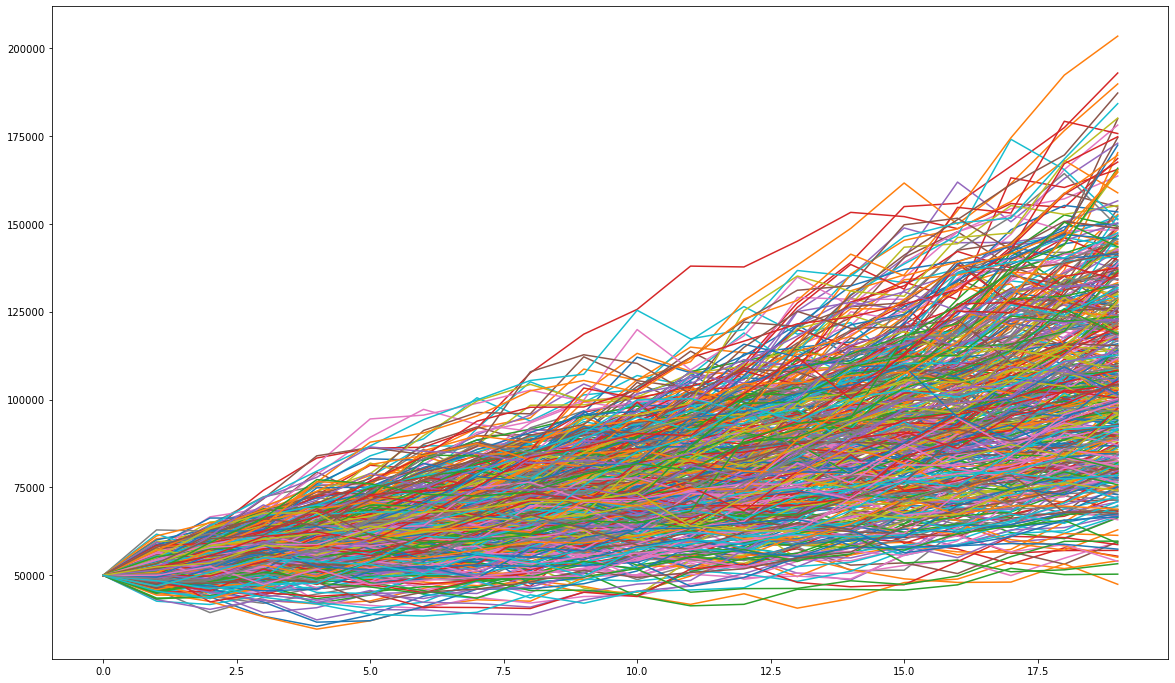

In [29]:
#plot the results. Ideally we could simply use this function to allow easily interchangable parameters 
simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).plot(figsize = (20,12), legend=None)

In [30]:
# Creates a new variable for the end results of the simulation
ending_values = simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).tail(1)

In [31]:
# Organizes ending results into one column
ending_values = ending_values.T
ending_values.columns = ['Ending Values']
ending_values

,Ending Values
0,69546.639628
1,122304.439583
2,161976.966491
3,117305.013330
4,66982.604660
...,...
495,167903.279051
496,69382.057679
497,96483.129441
498,88285.975335


<AxesSubplot:ylabel='Frequency'>

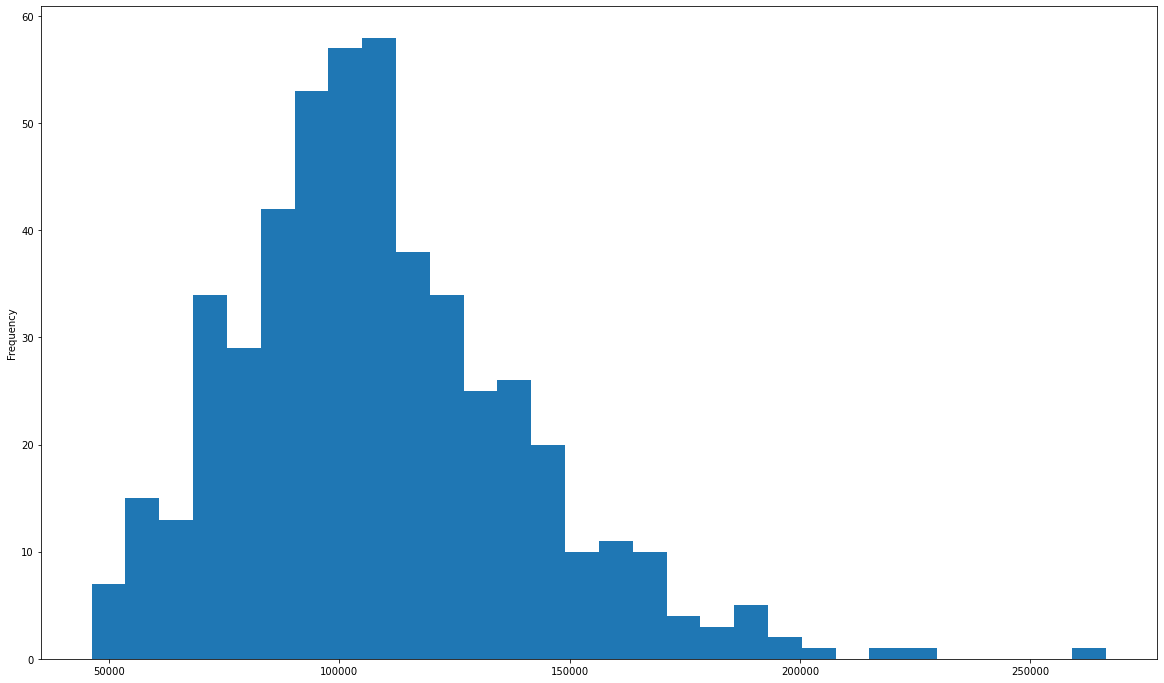

In [32]:
# Plots distribution of ending results.
ending_values.plot.hist(bins = 30, figsize = (20,12), legend=None)

In [33]:
# See summary statistics for ending results
ending_values.describe()

,Ending Values
count,500.000000
mean,108734.805047
std,31224.887920
min,46236.808239
25%,88262.326896
50%,104945.678893
75%,125779.749127
max,266477.477093
